In [1]:
library(ape)
library(tidyverse)
library(glue)
library(dplyr)
library(phytools)
library(nlme)
library(lme4)
library(lmerTest)
library(lmtest)
library(glmmTMB) 
library(phyloglmm)
library(LaplacesDemon) # documentation: https://rdrr.io/cran/phyr/man/pglmm.html
library(ggplot2)
library(ggpubr)
library(rstatix)
library(DHARMa)
library(betareg)
source("../../../code/feature_computation/utils.R")
library(pbmcapply)
library(vegan)
library(comprehenr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::where()  masks ape::where()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lme4’


The following object is masked from ‘pa

In [2]:
# process data
do_weighted = TRUE
include_metadata = FALSE

weighted_str = "unweighted" 
if (do_weighted)
    {
    weighted_str = "weighted" 
}
include_metadata_str = ""
if (include_metadata)
{
    include_metadata_str = "_with_mating_system"
}

features_of_interest = c("standardized_d", 
                         "standardized_partner.diversity", 
                         "standardized_normalised.degree", 
                         "standardized_weighted.betweenness", 
                         "standardized_weighted.closeness", 
                         "standardized_hubbiness_score")


data_path <- glue("../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{weighted_str}_networks{include_metadata_str}.csv")
pair_data_path = glue("../../../data/statistical_analysis/species_level/pair_data_on_{weighted_str}_networks.csv")
tree_path <- glue("../../../data/statistical_analysis/species_level/species_tree_on_{weighted_str}_networks{include_metadata_str}.nwk")
glmm_res_path = glue("../../../data/statistical_analysis/species_level/glmm_res_on_{weighted_str}_networks{include_metadata_str}.csv")
pglmm_res_path = glue("../../../data/statistical_analysis/species_level/phylogenetic_glmm_res_on_{weighted_str}_networks{include_metadata_str}.csv")
res_pair_path = glue("../../../data/statistical_analysis/species_level/pair_test_results_on_{weighted_str}_networks.csv")

unrooted_tree <- read.tree(tree_path)
tree <- multi2di(unrooted_tree)
tree <- makeNodeLabel(tree, method = "number", prefix = "Node")

data <- read.csv(data_path)
data$sample_id <- factor(data$sample_id)
data[["sample_id_numeric"]] <- as.numeric(data$sample_id)
rownames(data) <- data$sample_id

pair_data <- read.csv(pair_data_path)

In [3]:
round_df <- function(df, digits = 5) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

# perlimiary tests for phylogenetic signal in polyploidy trait

In [3]:
# perlimiary test of association of polyploidy with phylogenetic signal
# pagel's lambda
is_polyploid <- data %>% arrange(is_polyploid) %>% pull(is_polyploid, sample_id)
is_polyploid <- as.matrix(is_polyploid[order(match(is_polyploid, tree$tip.label))])
phylosig(tree, is_polyploid, method="lambda", test=TRUE, nsim=100, se=NULL, start=NULL,
	control=list())


Phylogenetic signal lambda : 0.999934 
logL(lambda) : 7000.92 
LR(lambda=0) : 19362.1 
P-value (based on LR test) : 0 


In [4]:
# d-statistic
ctree <- di2multi(tree)
cdata <- comparative.data(phy=ctree, data=data[c("sample_id", "is_polyploid")], names.col="sample_id")
res <- phylo.d(data=cdata, phy=ctree, binvar=is_polyploid)
summary(res)


Calculation of D statistic for the phylogenetic structure of a binary variable

  Data :  data[c("sample_id", "is_polyploid")]
  Binary variable :  is_polyploid
  Counts of states:  0 = 2039
                     1 = 1678
  Phylogeny :  ctree
  Number of permutations :  1000

Estimated D :  0.1092315
Probability of E(D) resulting from no (random) phylogenetic structure :  0
Probability of E(D) resulting from Brownian phylogenetic structure    :  0



# attepmt 0: pgls without random effect

In [3]:
w = diag(vcv.phylo(tree))
data["w"] = w

In [ ]:
if (include_metadata)
{    
    pgls_fit_d <- gls(standardized_d~is_polyploid+bs+is_polyploid*bs,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_d))

    pgls_fit_shanon <- gls(standardized_partner.diversity~is_polyploid+bs+is_polyploid*bs,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_shanon))
    
    pgls_fit_degree <- gls(standardized_normalised.degree~is_polyploid+bs+is_polyploid*bs,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_degree))

    pgls_fit_betweenness <- gls(standardized_weighted.betweenness~is_polyploid+bs+is_polyploid*bs,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_betweenness))

    pgls_fit_closeness <- gls(standardized_weighted.closeness~is_polyploid+bs+is_polyploid*bs,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_closeness))
    
    pgls_fit_hub <- gls(standardized_hubbiness_score~is_polyploid+bs+is_polyploid*bs,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_hub))

} else
{
    pgls_fit_d <- gls(standardized_d~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_d))

    pgls_fit_shanon <- gls(standardized_partner.diversity~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_shanon))
    
    pgls_fit_degree <- gls(standardized_normalised.degree~is_polyploid,
                 data=data, 
                 correlation=corBrownian(1,tree, form = ~sample_id),
                 weights=varFixed(~w))
    print(summary(pgls_fit_degree))

    pgls_fit_betweenness <- gls(standardized_weighted.betweenness~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_betweenness))

    pgls_fit_closeness <- gls(standardized_weighted.closeness~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_closeness))
    
    pgls_fit_hub <- gls(standardized_hubbiness_score~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_hub))

}

In [ ]:
if (include_metadata)
{
    print("\nmodels with no mating system on the smae dataset:\n")
    pgls_fit_d <- gls(standardized_d~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_d))

    pgls_fit_shanon <- gls(standardized_partner.diversity~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_shanon))

    pgls_fit_betweenness <- gls(standardized_weighted.betweenness~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_betweenness))

    pgls_fit_closeness <- gls(standardized_weighted.closeness~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_closeness))

    pgls_fit_degree <- gls(standardized_normalised.degree~is_polyploid,
                     data=data, 
                     correlation=corBrownian(1,tree, form = ~sample_id),
                     weights=varFixed(~w))
    print(summary(pgls_fit_degree))
}

# attempt 1: glmm with random effects (no phylogeny)

In [151]:
data$is_polyploid <- factor(data$is_polyploid)

In [505]:
test_ploidy_level_effect <- function(response_var, include_metadata){
    fixed_covars = c("is_polyploid")
    random_covars = c("network_id", "network_size")
    if (include_metadata)
    {
        fixed_covars = c("is_polyploid", "bs", "(bs*is_polyploid)")
    }
    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
  
    complete_formula = as.formula(complete_formula_str)
    model.full <- glmmTMB(formula=complete_formula
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , data=data
                    , control= glmmTMBControl(), #rank_check = "skip")
                    , start = list(psi = c(-1, 1))
                    )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = model_res$coefficients$cond
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- glmmTMB(formula=as.formula(formula_str)
                        , family=ordbeta(link = "logit")
                        , ziformula=~1
                        , data=data
                        , control= glmmTMBControl(), #rank_check = "skip")
                        , start = list(psi = c(-1, 1))
                        )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                                      
    for (random_var in random_covars)
    {
        subset_random_covars = random_covars[which(random_covars != random_var)]
        fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        model.reduced <- glmmTMB(formula=as.formula(formula_str)
                        , family=ordbeta(link = "logit")
                        , ziformula=~1
                        , data=data
                        , control= glmmTMBControl(), #rank_check = "skip")
                        , start = list(psi = c(-1, 1))
                        )
        lrt <- anova(model.full, model.reduced)
        res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
    return (res_df)
}

## sepcialization index d

 Family: ordbeta  ( logit )
Formula:          
standardized_d ~ is_polyploid + (1 | network_id) + (1 | network_size)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1127.3   1178.3   -555.6   1111.3     4332 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 2.321e-11 4.818e-06
 network_size (Intercept) 4.505e-11 6.712e-06
Number of obs: 4340, groups:  network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.66 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)   -0.03956    0.02071  -1.910   0.0561 .
is_polyploid1  0.04873    0.03106   1.569   0.1166  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -26.57    8951.41  -0.003    0.998


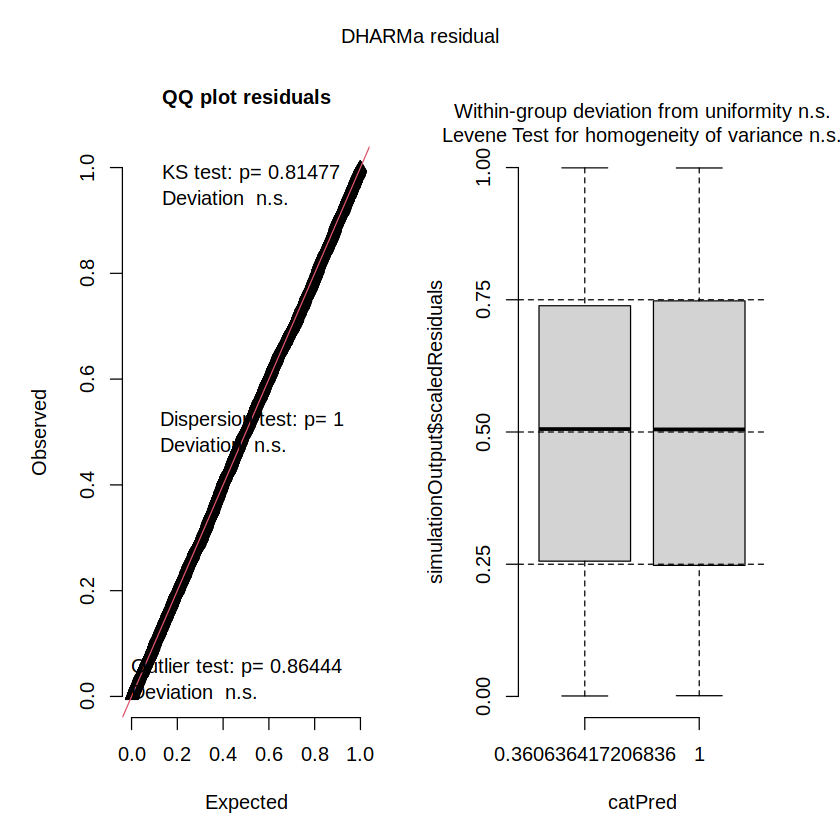

In [506]:
d_res_df = test_ploidy_level_effect(response_var="standardized_d",
                         include_metadata=include_metadata)

In [507]:
d_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_d,none,NA,NA,-0.03956482,0.02071500,-1.90996,0.05613834
is_polyploid,standardized_d,fixed,2.461637,0.1166571,0.04873436,0.03105701,1.56919,0.11660364
network_id,standardized_d,random,0.000000,1.0000000,NA,NA,NA,NA
network_size,standardized_d,random,0.000000,1.0000000,NA,NA,NA,NA


## shannon diversity

 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1680.8   1731.8   -832.4   1664.8     4332 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 3.809e-12 1.952e-06
 network_size (Intercept) 1.298e-10 1.139e-05
Number of obs: 4340, groups:  network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.89 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)    0.01177    0.02033   0.579   0.5627  
is_polyploid1  0.05749    0.03031   1.897   0.0579 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.05    4184.32  -0.006    0.995


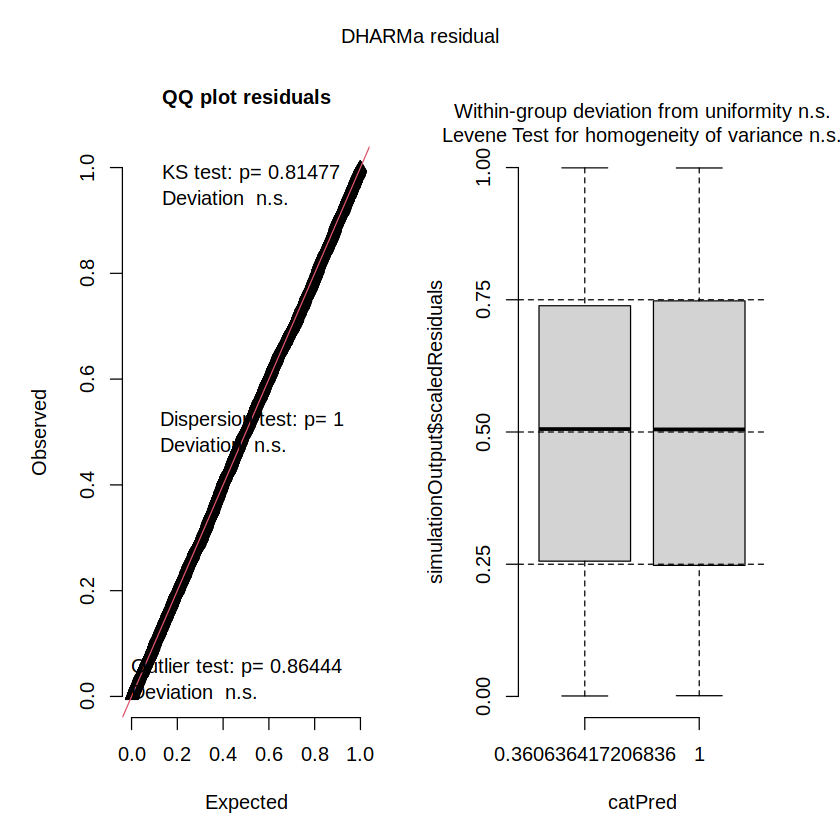

In [508]:
sd_res_df = test_ploidy_level_effect(response_var="standardized_partner.diversity",
                         include_metadata=include_metadata)

In [509]:
sd_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_partner.diversity,none,NA,NA,0.01176741,0.02032769,0.5788856,0.56266639
is_polyploid,standardized_partner.diversity,fixed,3.596692,0.05789465,0.05748863,0.03030792,1.8968190,0.05785183
network_id,standardized_partner.diversity,random,0.000000,1.00000000,NA,NA,NA,NA
network_size,standardized_partner.diversity,random,0.000000,1.00000000,NA,NA,NA,NA


## normalized degree

 Family: ordbeta  ( logit )
Formula:          
standardized_normalised.degree ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1773.0   1824.0   -878.5   1757.0     4332 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 4.019e-11 6.340e-06
 network_size (Intercept) 6.020e-11 7.759e-06
Number of obs: 4340, groups:  network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.97 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)   0.009081   0.020170   0.450   0.6525  
is_polyploid1 0.058631   0.030086   1.949   0.0513 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)      -26       6712  -0.004    0.997


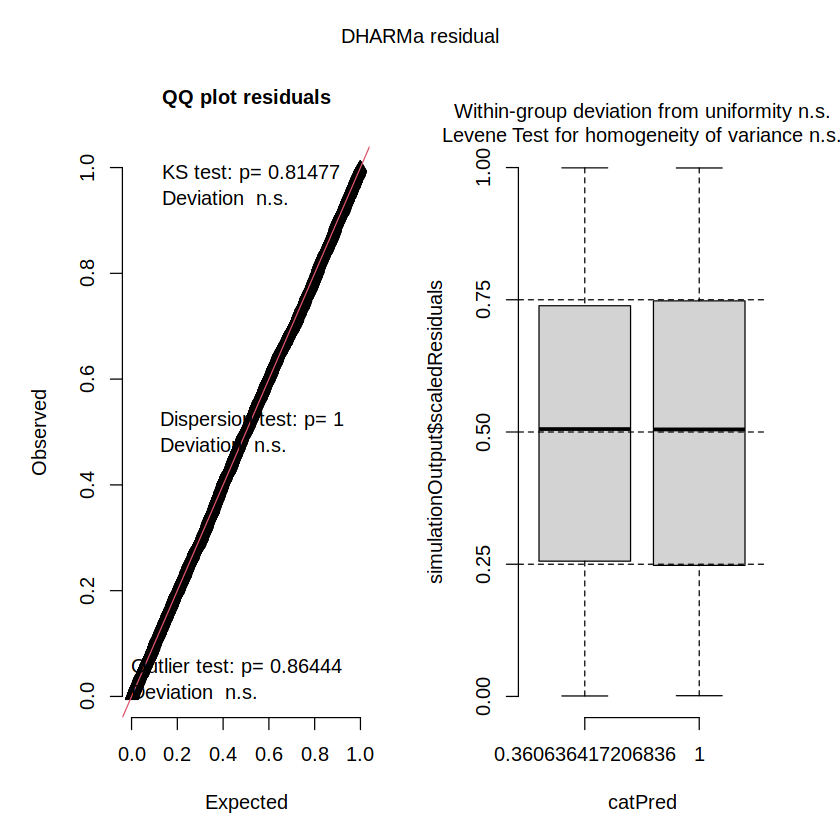

In [510]:
nd_res_df = test_ploidy_level_effect(response_var="standardized_normalised.degree",
                         include_metadata=include_metadata)

In [511]:
nd_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_normalised.degree,none,NA,NA,0.009081028,0.02016992,0.4502263,0.65254728
is_polyploid,standardized_normalised.degree,fixed,3.796756,0.05135197,0.058631213,0.03008588,1.9487951,0.05131989
network_id,standardized_normalised.degree,random,0.000000,1.00000000,NA,NA,NA,NA
network_size,standardized_normalised.degree,random,0.000000,1.00000000,NA,NA,NA,NA


## betweenness

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1100.5   1151.5   -542.2   1084.5     4332 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 2.518e-12 1.587e-06
 network_size (Intercept) 9.033e-12 3.006e-06
Number of obs: 4340, groups:  network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 4.16 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.092928   0.017903   5.191  2.1e-07 ***
is_polyploid1 0.005686   0.026922   0.211    0.833    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -27.79   16436.55  -0.002    0.999


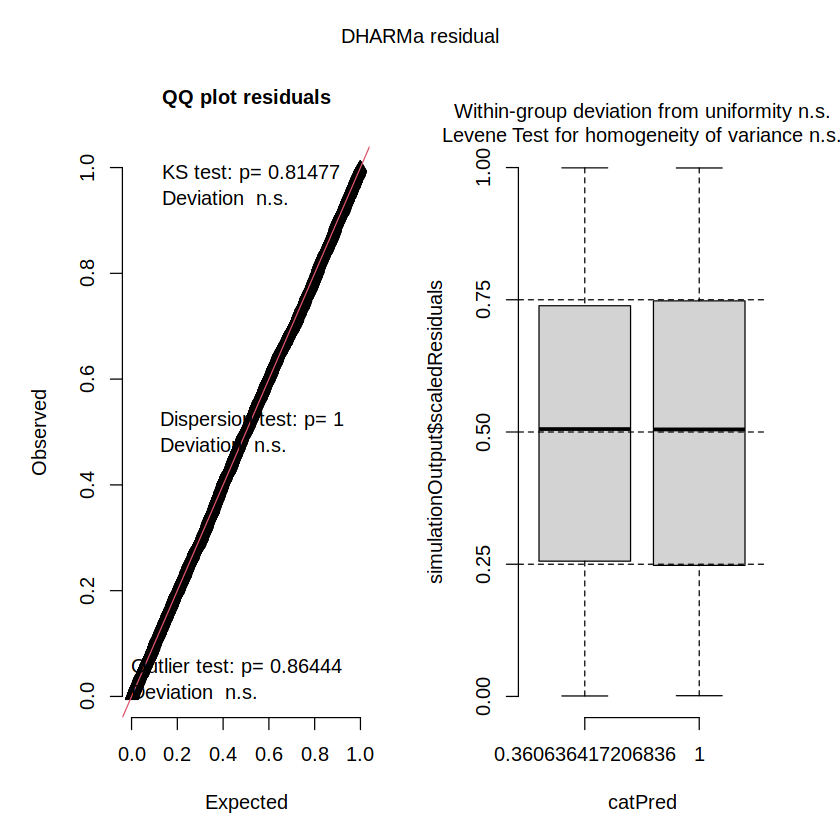

In [512]:
bet_res_df = test_ploidy_level_effect(response_var="standardized_weighted.betweenness",
                         include_metadata=include_metadata)

In [513]:
bet_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_weighted.betweenness,none,NA,NA,0.092928254,0.01790311,5.1906203,2.095946e-07
is_polyploid,standardized_weighted.betweenness,fixed,4.460183e-02,0.8327379,0.005685587,0.02692226,0.2111854,8.327426e-01
network_id,standardized_weighted.betweenness,random,2.774414e-08,0.9998671,NA,NA,NA,NA
network_size,standardized_weighted.betweenness,random,4.815297e-08,0.9998249,NA,NA,NA,NA


## closeness

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.closeness ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                   ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1905.3   1956.3   -944.7   1889.3     4332 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 6.258e-11 7.910e-06
 network_size (Intercept) 7.738e-12 2.782e-06
Number of obs: 4340, groups:  network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.61 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)   -0.04102    0.02096  -1.957   0.0504 .
is_polyploid1  0.03042    0.03130   0.972   0.3311  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -26.8    10026.2  -0.003    0.998


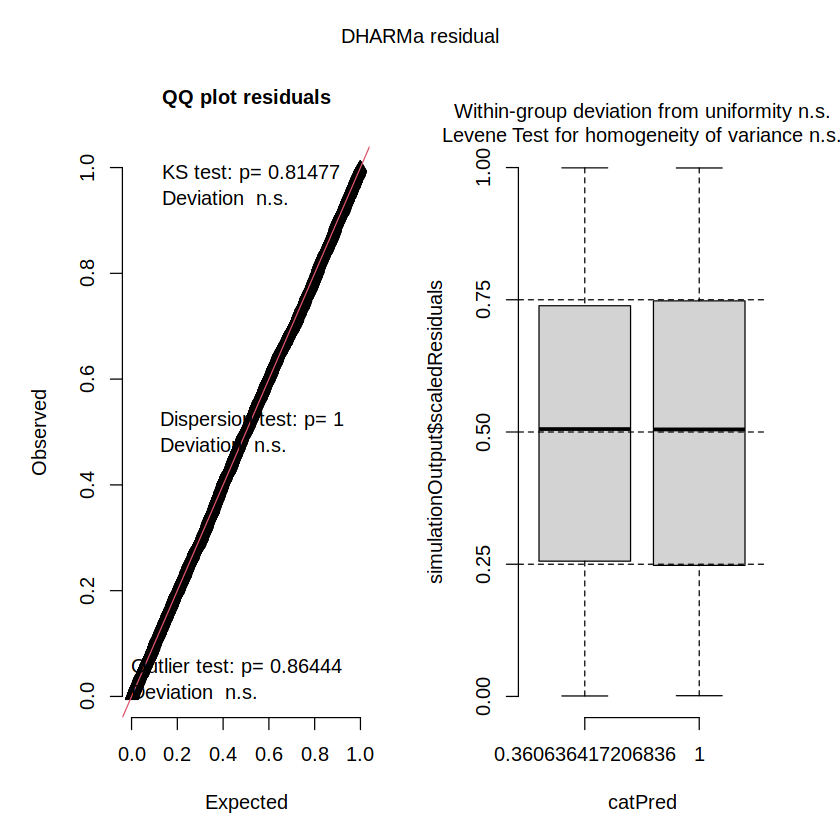

In [514]:
clos_res_df = test_ploidy_level_effect(response_var="standardized_weighted.closeness",
                         include_metadata=include_metadata)

In [515]:
clos_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_weighted.closeness,none,NA,NA,-0.04101540,0.02096092,-1.9567563,0.05037613
is_polyploid,standardized_weighted.closeness,fixed,9.446689e-01,0.3310800,0.03042037,0.03129793,0.9719611,0.33106988
network_id,standardized_weighted.closeness,random,6.061373e-08,0.9998036,NA,NA,NA,NA
network_size,standardized_weighted.closeness,random,2.461161e-08,0.9998748,NA,NA,NA,NA


### hub score

 Family: ordbeta  ( logit )
Formula:          
standardized_hubbiness_score ~ is_polyploid + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                                ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1513.3   1564.4   -748.7   1497.3     4332 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 network_id   (Intercept) 4.858e-11 6.970e-06
 network_size (Intercept) 1.182e-12 1.087e-06
Number of obs: 4340, groups:  network_id, 512; network_size, 139

Dispersion parameter for ordbeta family (): 2.79 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.01479    0.02051   0.721    0.471
is_polyploid1  0.02930    0.03063   0.957    0.339

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.59    5468.49  -0.005    0.996


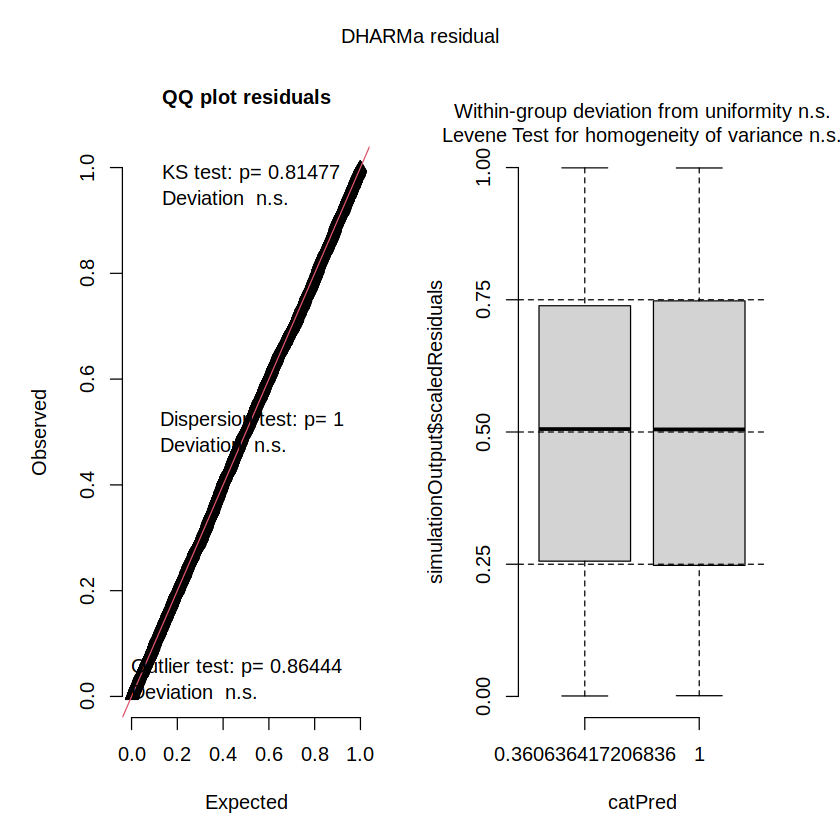

In [516]:
hub_res_df = test_ploidy_level_effect(response_var="standardized_hubbiness_score",
                         include_metadata=include_metadata)

In [517]:
hub_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_hubbiness_score,none,NA,NA,0.01479238,0.02051259,0.7211367,0.4708254
is_polyploid,standardized_hubbiness_score,fixed,0.9152925,0.338714,0.02930114,0.03062536,0.9567606,0.3386881
network_id,standardized_hubbiness_score,random,0.0000000,1.000000,NA,NA,NA,NA
network_size,standardized_hubbiness_score,random,0.0000000,1.000000,NA,NA,NA,NA


In [526]:
full_df = rbind(rbind(rbind(rbind(rbind(d_res_df, sd_res_df),nd_res_df),bet_res_df),clos_res_df),hub_res_df)
full_df["significant_by_lrt"] = full_df$lrt_pvalue <= 0.05
full_df["significant_by_wald_test"] = full_df$z_test_pvalue <= 0.05
write.csv(full_df, glmm_res_path)
full_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,significant_by_lrt,significant_by_wald_test
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Intercept,standardized_d,none,NA,NA,0.035247027,0.13335327,0.2643132,7.915386e-01,NA,FALSE
is_polyploid,standardized_d,fixed,2.668757e+00,0.10233593,0.063387119,0.03880665,1.6334087,1.023831e-01,FALSE,FALSE
network_id,standardized_d,random,4.143476e-08,0.99983759,NA,NA,NA,NA,FALSE,NA
network_size,standardized_d,random,6.084156e-08,0.99980319,NA,NA,NA,NA,FALSE,NA
sample_id,standardized_d,random,NA,NA,NA,NA,NA,NA,NA,NA
Intercept1,standardized_partner.diversity,none,NA,NA,0.011767408,0.02032769,0.5788856,5.626664e-01,NA,FALSE
is_polyploid1,standardized_partner.diversity,fixed,3.596692e+00,0.05789465,0.057488631,0.03030792,1.8968190,5.785183e-02,FALSE,FALSE
network_id1,standardized_partner.diversity,random,0.000000e+00,1.00000000,NA,NA,NA,NA,FALSE,NA
network_size1,standardized_partner.diversity,random,0.000000e+00,1.00000000,NA,NA,NA,NA,FALSE,NA


# attempt 2: phylogenetic glmm with random effects

In [4]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

test_phylo_ploidy_level_effect <- function(response_var, include_metadata){
    fixed_covars = c("is_polyploid")
    random_covars = c("sample_id", "network_id", "network_size")
    if (include_metadata)
    {
        fixed_covars = c("is_polyploid", "bs", "(bs*is_polyploid)")
    }
    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
  
    complete_formula = as.formula(complete_formula_str)
    
    model.full <- phylo_glmmTMB(formula=complete_formula
                            , family=ordbeta(link = "logit")
                            , ziformula=~1
                            , data=data
                            , phylonm = "sample_id"
                            , phylo = tree
                            , control= glmmTMBControl(rank_check = "skip"),
                            )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = model_res$coefficients$cond
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- phylo_glmmTMB(formula=as.formula(formula_str)
                            , family=ordbeta(link = "logit")
                            , ziformula=~1
                            , data=data
                            , phylonm = "sample_id"
                            , phylo = tree
                            , control= glmmTMBControl(rank_check = "skip"),
                            )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                                      
    for (random_var in random_covars)
    {
        subset_random_covars = random_covars[which(random_covars != random_var)]
        fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        model.reduced <- phylo_glmmTMB(formula=as.formula(formula_str)
                        , family=ordbeta(link = "logit")
                        , ziformula=~1
                        , data=data
                        , phylonm = "sample_id"
                        , phylo = tree
                        , control= glmmTMBControl(rank_check = "skip"),
                        )
        lrt <- anova(model.full, model.reduced)
        res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
    return (res_df)
}

In [5]:
data$is_polyploid = factor(data$is_polyploid)

## specialization index d

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


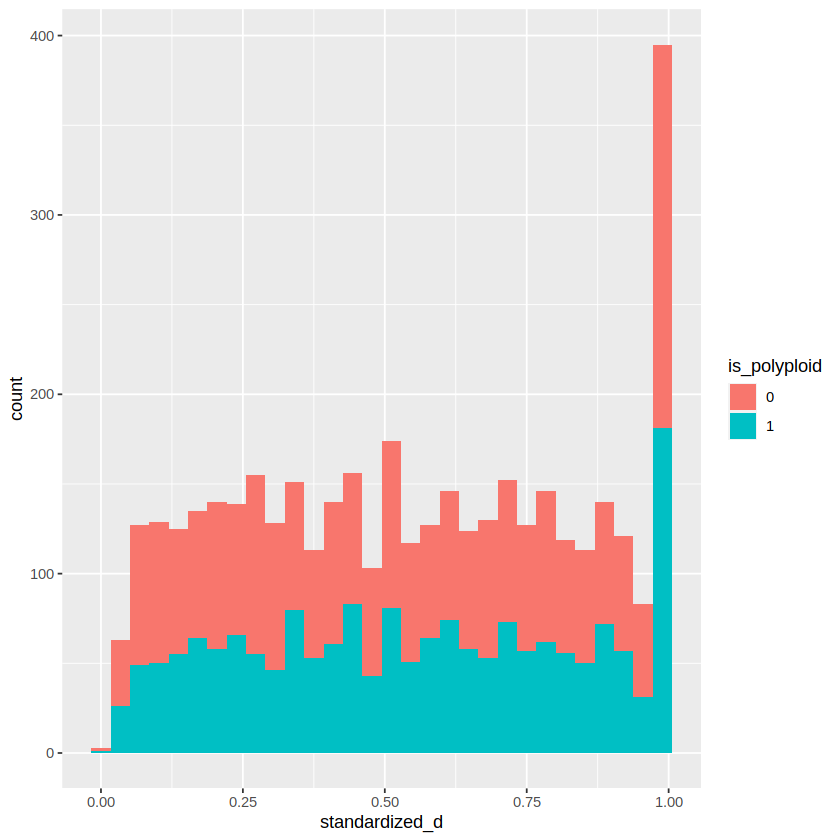

In [6]:
ggplot(data, aes(x = standardized_d, fill = is_polyploid)) + geom_histogram()

 Family: ordbeta  ( logit )
Formula:          
standardized_d ~ is_polyploid + (1 | sample_id) + (1 | network_id) +  
    (1 | network_size)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  2202.6   2259.3  -1092.3   2184.6     4012 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 1.433e-03 3.786e-02
 network_id   (Intercept) 2.732e-11 5.227e-06
 network_size (Intercept) 3.469e-12 1.862e-06
Number of obs: 4021, groups:  
sample_id, 4021; network_id, 459; network_size, 131

Dispersion parameter for ordbeta family (): 2.92 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)    0.03351    0.12273   0.273    0.785
is_polyploid1  0.06313    0.03966   1.592    0.111

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -25.31    4929.19  -0.005    0.996


Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


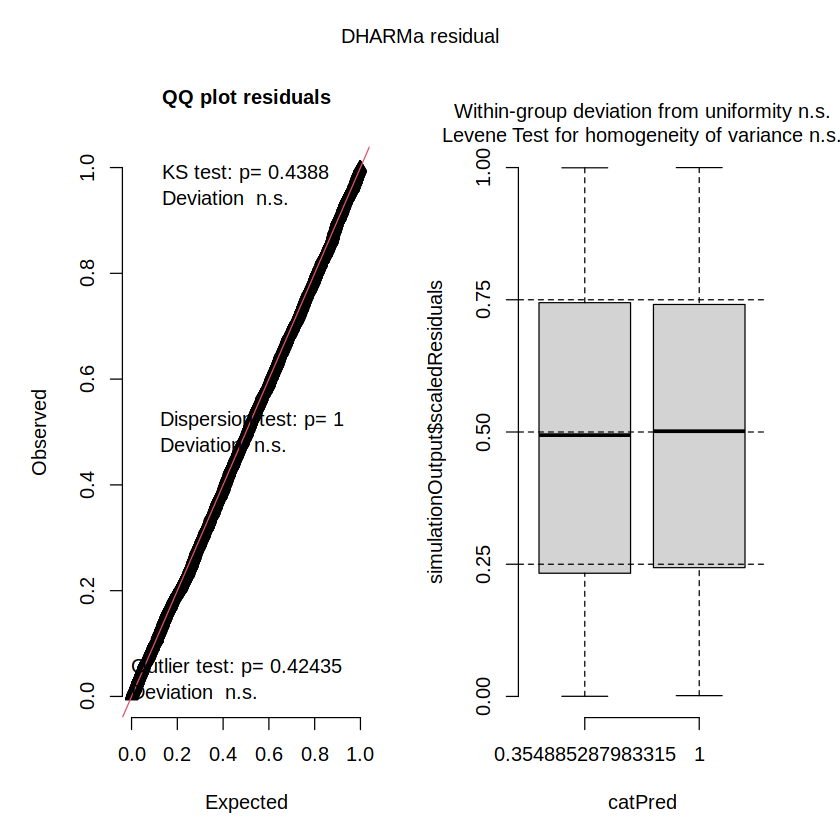

In [7]:
d_res_df = test_phylo_ploidy_level_effect(response_var="standardized_d",
                         include_metadata=include_metadata)

In [8]:
d_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_d,none,NA,NA,0.03350539,0.12272575,0.2730102,0.7848453
is_polyploid,standardized_d,fixed,2.528944e+00,1.117750e-01,0.06313202,0.03966401,1.5916703,0.1114588
network_id,standardized_d,random,9.231371e-09,9.999233e-01,NA,NA,NA,NA
network_size,standardized_d,random,0.000000e+00,1.000000e+00,NA,NA,NA,NA
sample_id,standardized_d,random,9.474520e+01,2.165377e-22,NA,NA,NA,NA


## shannon diversity

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


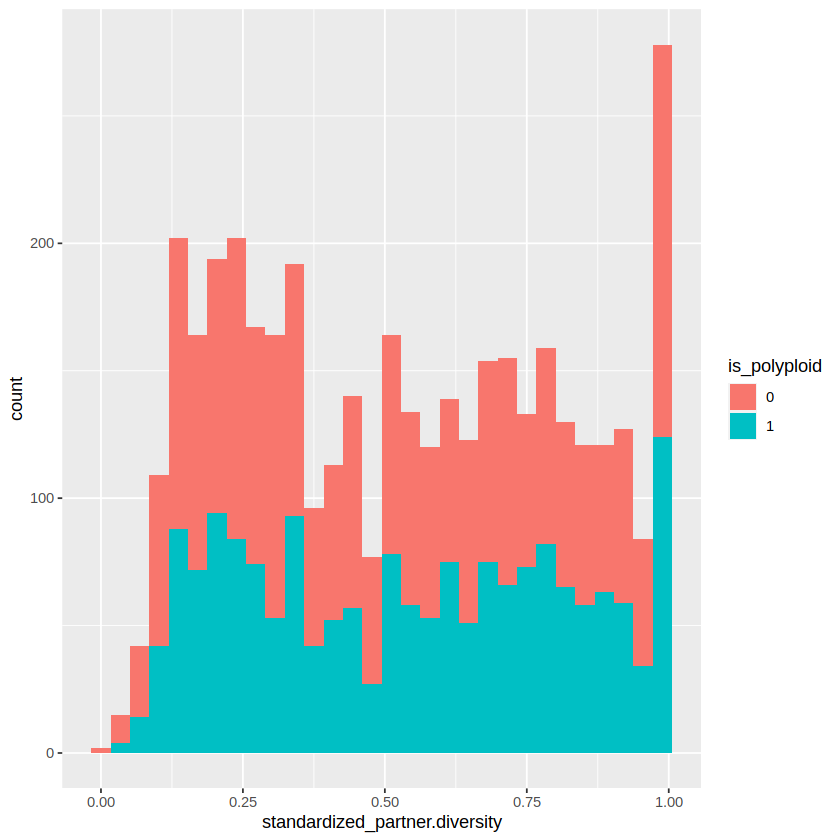

In [9]:
ggplot(data, aes(x = standardized_partner.diversity, fill = is_polyploid)) + geom_histogram()

 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1191.2   1247.9   -586.6   1173.2     4012 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 4.782e-03 6.915e-02
 network_id   (Intercept) 2.250e-13 4.743e-07
 network_size (Intercept) 6.231e-13 7.893e-07
Number of obs: 4021, groups:  
sample_id, 4021; network_id, 459; network_size, 131

Dispersion parameter for ordbeta family (): 3.62 

Conditional model:
              Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.16337    0.21115  -0.774    0.439
is_polyploid1  0.01313    0.04366   0.301    0.764

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)    -27.1    12099.8  -0.002    0.998


Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


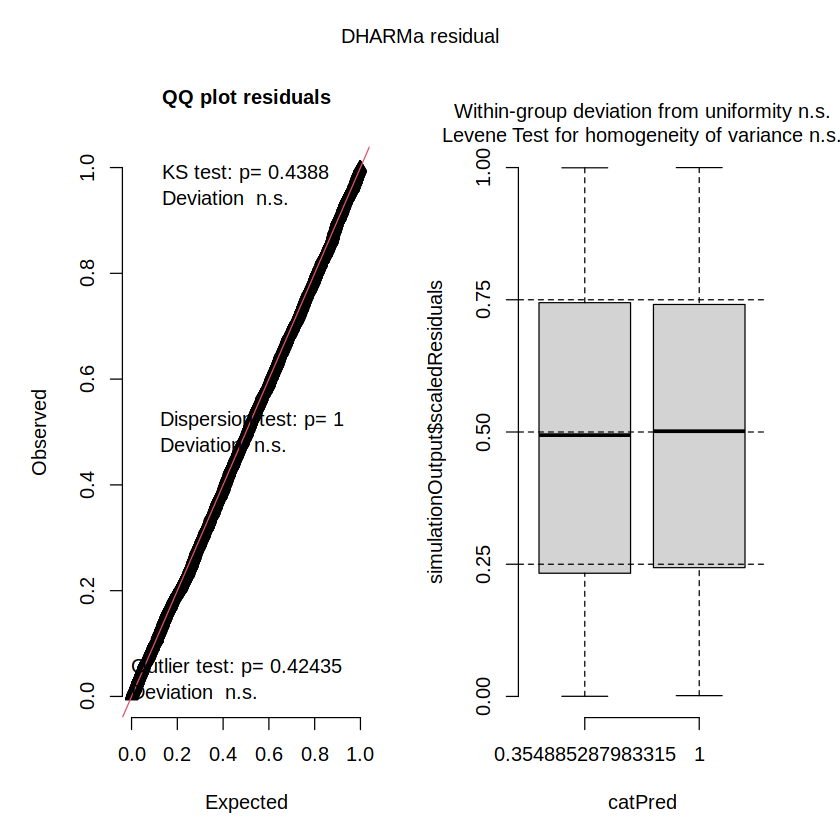

In [10]:
sd_res_df = test_phylo_ploidy_level_effect(response_var="standardized_partner.diversity",
                         include_metadata=include_metadata)

In [11]:
sd_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,standardized_partner.diversity,none,NA,NA,-0.16337231,0.21115163,-0.7737203,0.4390962
is_polyploid,standardized_partner.diversity,fixed,9.035062e-02,7.637319e-01,0.01312919,0.04366238,0.3006980,0.7636448
network_id,standardized_partner.diversity,random,1.095577e-08,9.999165e-01,NA,NA,NA,NA
network_size,standardized_partner.diversity,random,3.245077e-08,9.998563e-01,NA,NA,NA,NA
sample_id,standardized_partner.diversity,random,3.897805e+02,9.239932e-87,NA,NA,NA,NA


## normalized degree

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


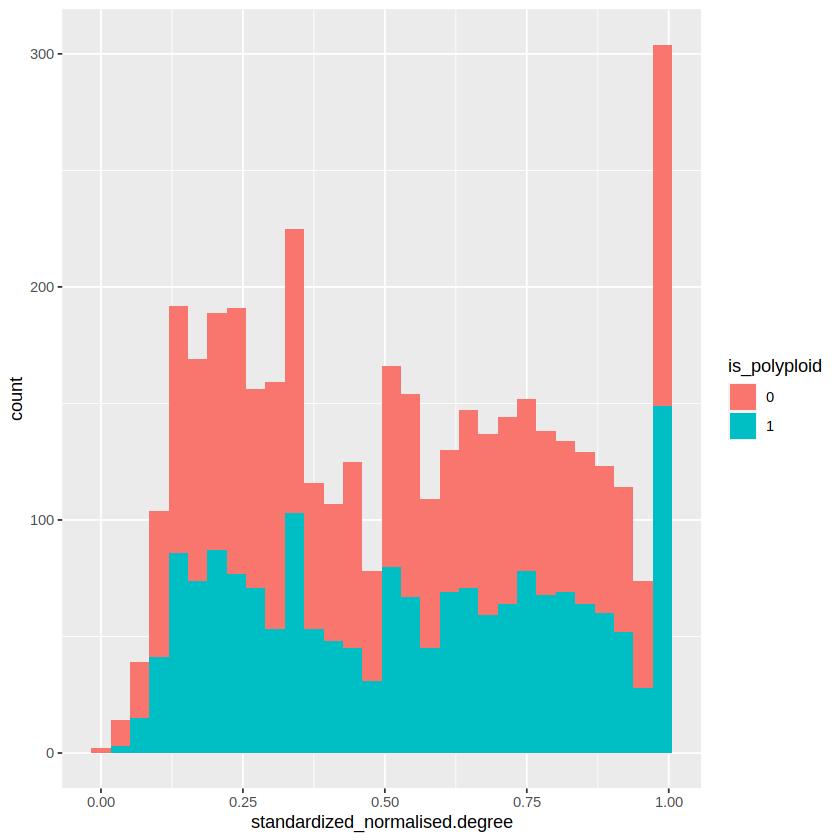

In [12]:
ggplot(data, aes(x = standardized_normalised.degree, fill = is_polyploid)) + geom_histogram()

In [ ]:
nd_res_df = test_phylo_ploidy_level_effect(response_var="standardized_normalised.degree",
                         include_metadata=include_metadata)

In [ ]:
nd_res_df

## betweenness

In [ ]:
ggplot(data, aes(x = standardized_weighted.betweenness, fill = is_polyploid)) + geom_histogram()

In [ ]:
bet_res_df = test_phylo_ploidy_level_effect(response_var="standardized_weighted.betweenness",
                         include_metadata=include_metadata)

 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + (1 | sample_id) +  
    (1 | network_id) + (1 | network_size)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
   838.7    895.4   -410.4    820.7     4012 

Random effects:

Conditional model:
 Groups       Name        Variance  Std.Dev. 
 sample_id    (Intercept) 2.477e-03 4.977e-02
 network_id   (Intercept) 8.297e-12 2.880e-06
 network_size (Intercept) 7.966e-13 8.925e-07
Number of obs: 4021, groups:  
sample_id, 4021; network_id, 459; network_size, 131

Dispersion parameter for ordbeta family (): 5.04 

Conditional model:
               Estimate Std. Error z value Pr(>|z|)
(Intercept)   -0.085351   0.154300  -0.553    0.580
is_polyploid1  0.001889   0.036369   0.052    0.959

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)      -26       6984  -0.004    0.997


Warning message in checkTerms(data.tmb1$terms, data.tmb0$terms):
“Predicting new random effect levels for terms: 1 | sample_id
Disable this warning with 'allow.new.levels=TRUE'”


In [ ]:
bet_res_df

# closeness

In [ ]:
ggplot(data, aes(x = standardized_weighted.closeness, fill = is_polyploid)) + geom_histogram()

In [ ]:
clos_res_df = test_phylo_ploidy_level_effect(response_var="standardized_weighted.closeness",
                         include_metadata=include_metadata)

In [ ]:
clos_res_df

## hub score

In [ ]:
ggplot(data, aes(x = standardized_hubbiness_score, fill = is_polyploid)) + geom_histogram()

In [ ]:
hub_res_df = test_phylo_ploidy_level_effect(response_var="standardized_hubbiness_score",
                         include_metadata=include_metadata)

In [ ]:
hub_res_df

In [ ]:
full_df = rbind(rbind(rbind(rbind(rbind(d_res_df, sd_res_df),nd_res_df),bet_res_df),clos_res_df),hub_res_df)
full_df["significant_by_lrt"] = full_df$lrt_pvalue <= 0.05
full_df["significant_by_wald_test"] = full_df$z_test_pvalue <= 0.05
write.csv(full_df, pglmm_res_path)

In [ ]:
round_df(full_df)

# pair analysis

In [551]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

test_pair_ploidy_level_effect <- function(response_var){
    func_data = pair_data %>% drop_na(response_var)
    fixed_covars = c("pair_type")
    random_covars = c("network_id", "phylogenetic_dist")
    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
  
    complete_formula = as.formula(complete_formula_str)
    
    model.full <- glmmTMB(formula=complete_formula, 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=func_data
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = model_res$coefficients$cond
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) str_replace(gsub('[^[:alpha:]^_]', '', item), "typepd", "type"))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- glmmTMB(formula=as.formula(formula_str), 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=func_data
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                                      
    for (random_var in random_covars)
    {
        if (random_var != "sample_id")
        {
            subset_random_covars = random_covars[which(random_covars != random_var)]
            fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
            random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
            formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
            model.reduced <- glmmTMB(formula=as.formula(formula_str), 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=func_data
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
            lrt <- anova(model.full, model.reduced)
            res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
            res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
        }
    }
    return (res_df)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


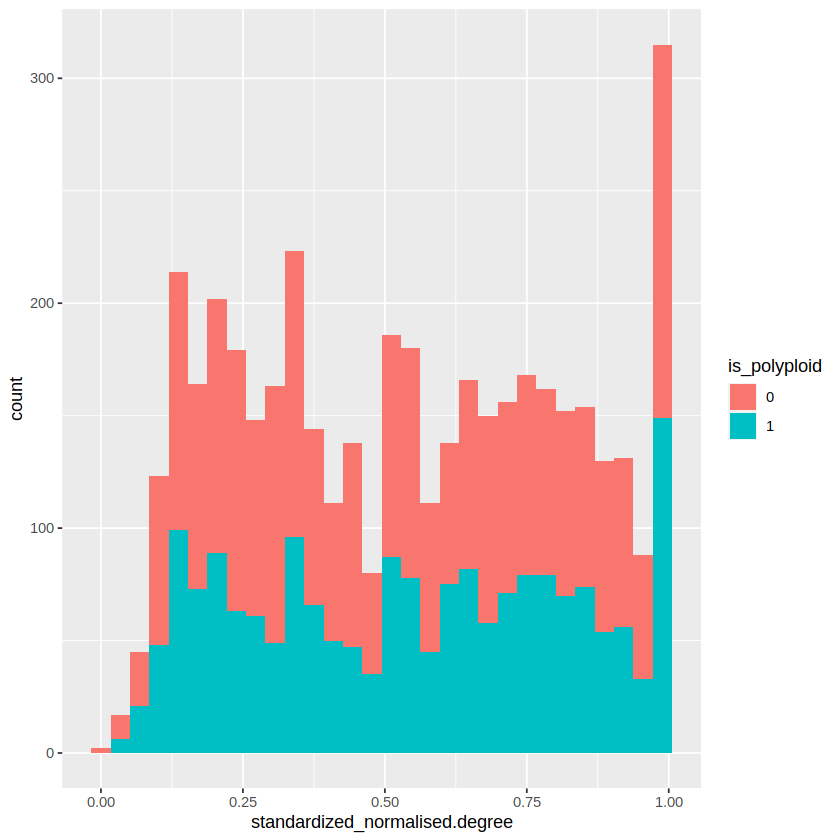

In [540]:
ggplot(data, aes(x = standardized_normalised.degree, fill = is_polyploid)) + geom_histogram()
if (include_metadata)
{
glmm_fit <- phylo_glmmTMB(formula=standardized_normalised.degree~is_polyploid+bs+(is_polyploid*bs)+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("full model")
print(summary(glmm_fit))
    
glmm_fit_reduced <- phylo_glmmTMB(formula=standardized_normalised.degree~bs+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("\nreduced model")
print(summary(glmm_fit_reduced))
} else
{
glmm_fit <- phylo_glmmTMB(formula=standardized_normalised.degree~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("full model")
print(summary(glmm_fit))
    
glmm_fit_reduced <- phylo_glmmTMB(formula=standardized_normalised.degree~(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("\nreduced model")
print(summary(glmm_fit_reduced))
}
print("\nmodel comparison")
print(summary(lrtest(glmm_fit, glmm_fit_reduced)))
print("\nmodel diagnostics")
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

## deprecated - perform test on poly-diplo pairs

In [31]:
mixed = glmmTMB(formula=standardized_d_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_d_diff ~ pair_type + (1 | network_id) + (1 | phylogenetic_dist)
Zero inflation:                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -628.2   -596.5    320.1   -640.2     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.01158  0.1076  
 phylogenetic_dist (Intercept) 0.01132  0.1064  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 4.59 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.78608    0.03758 -20.915   <2e-16 ***
pair_typepd  0.01214    0.04882   0.249    0.804    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.1744     0.2148  -19.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05

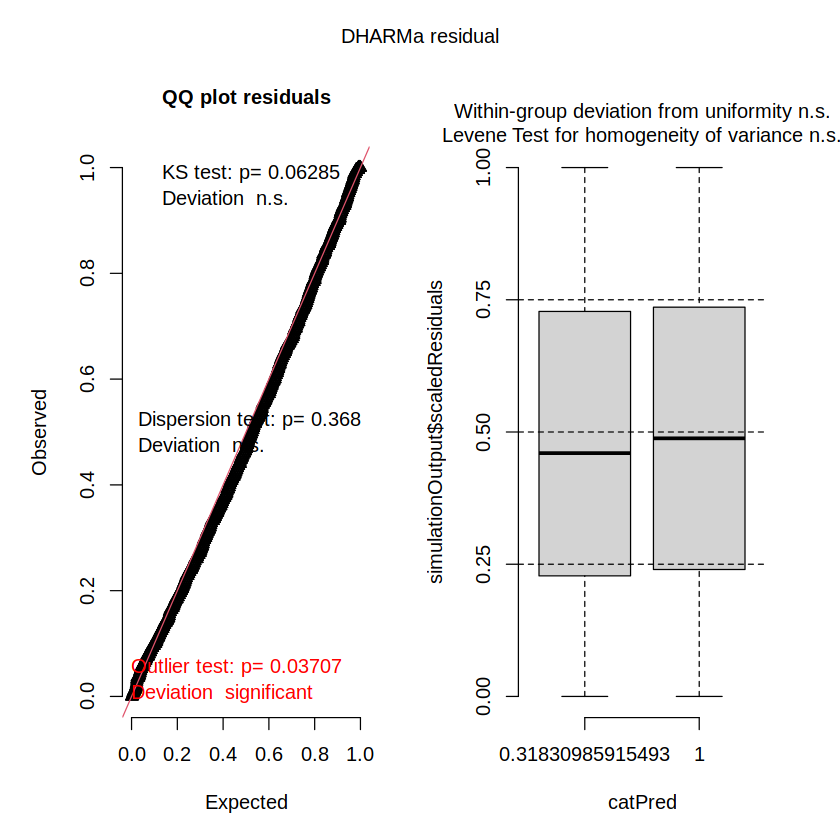

In [32]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


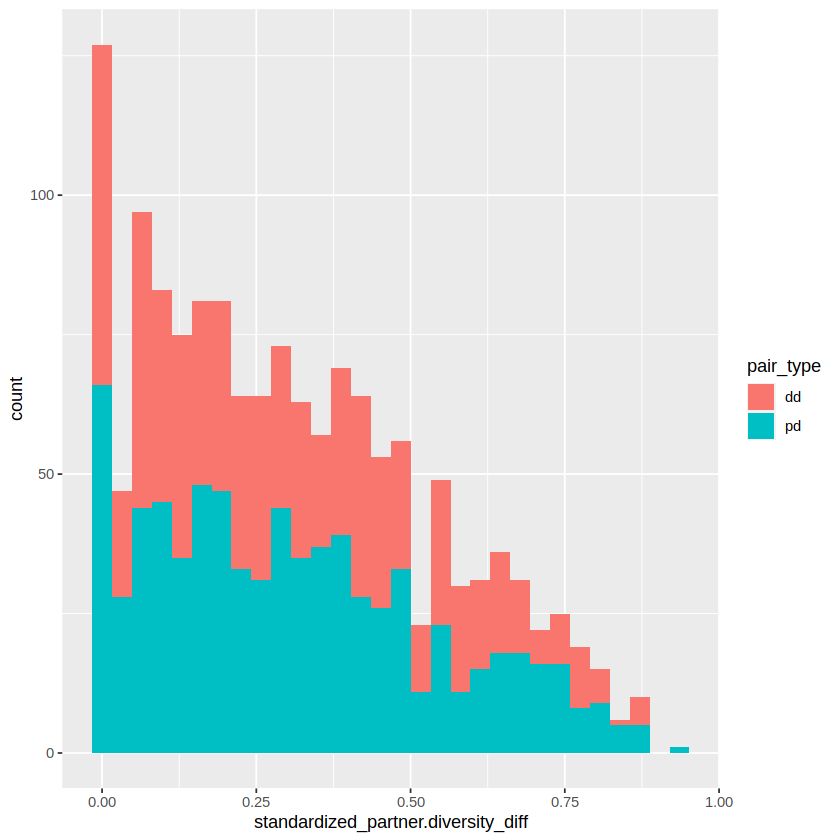

In [33]:
ggplot(pair_data, aes(x=standardized_partner.diversity_diff, fill = pair_type)) + geom_histogram()

In [34]:
mixed = glmmTMB(formula=standardized_partner.diversity_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_partner.diversity_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   134.9    166.6    -61.5    122.9     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.05653  0.2378  
 phylogenetic_dist (Intercept) 0.07794  0.2792  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 4.86 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.65107    0.04656 -13.985   <2e-16 ***
pair_typepd  0.01039    0.05698   0.182    0.855    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.43451    0.09642  -25.25   <2e-16 ***
---
Signif. co

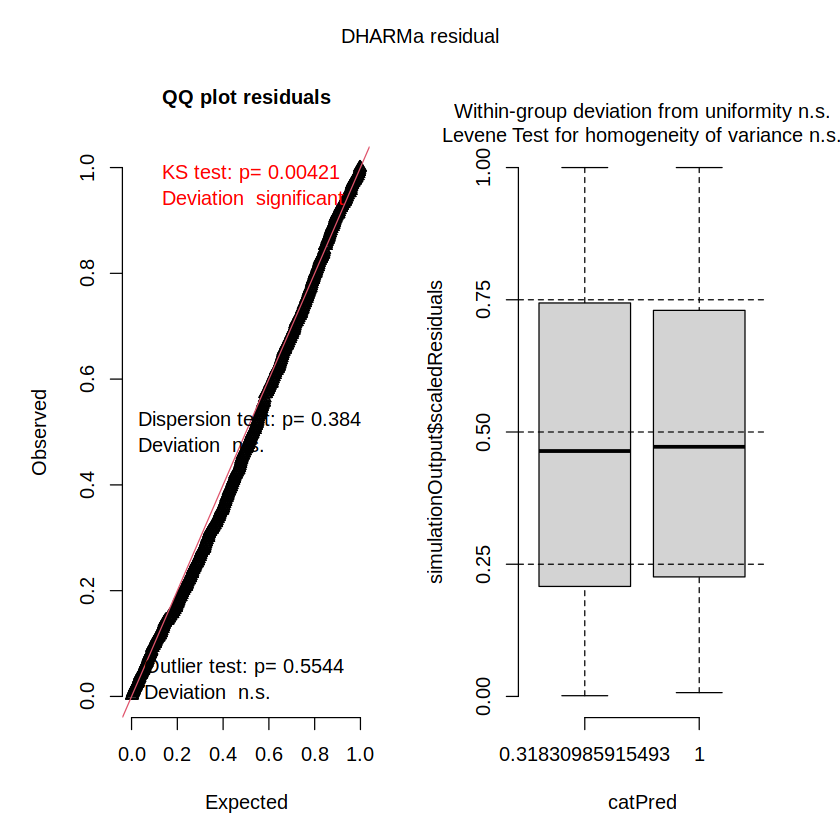

In [35]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


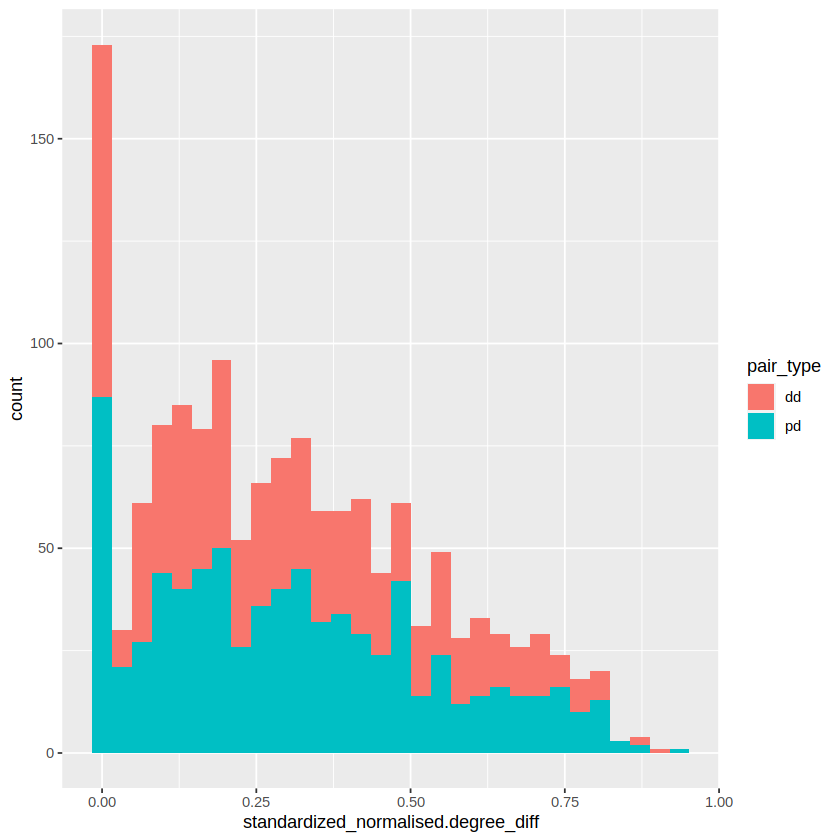

In [36]:
ggplot(pair_data, aes(x=standardized_normalised.degree_diff, fill = pair_type)) + geom_histogram()

In [37]:
mixed = glmmTMB(formula=standardized_normalised.degree_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_normalised.degree_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   370.6    402.3   -179.3    358.6     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.05961  0.2441  
 phylogenetic_dist (Intercept) 0.06366  0.2523  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 5.47 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.60420    0.04542 -13.303   <2e-16 ***
pair_typepd  0.02585    0.05492   0.471    0.638    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.00054    0.08101   -24.7   <2e-16 ***
---
Signif. co

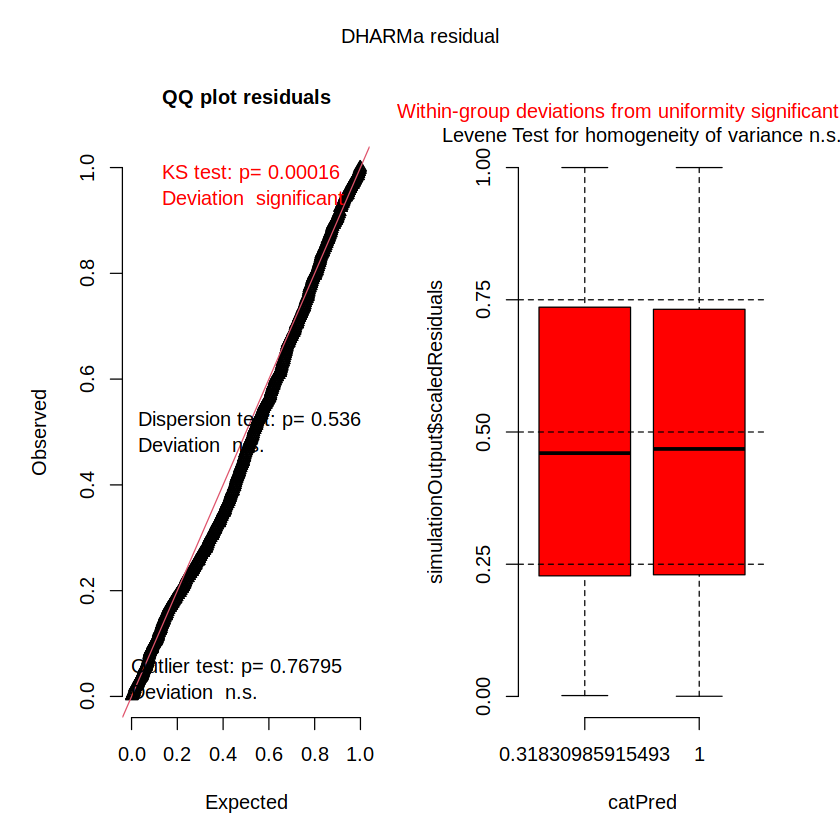

In [38]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


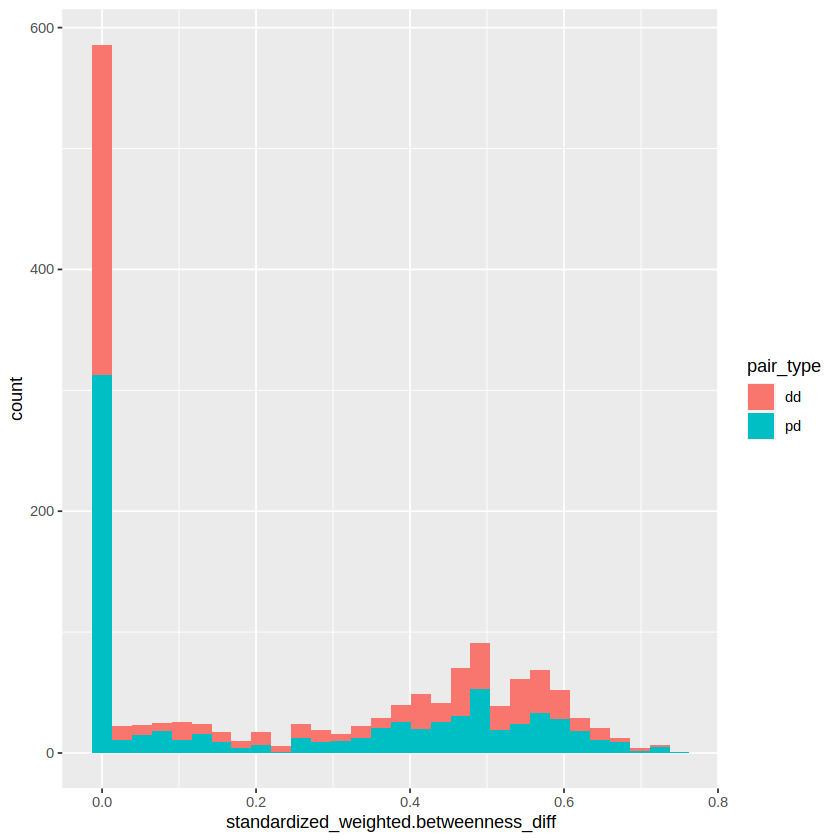

In [39]:
ggplot(pair_data, aes(x=standardized_weighted.betweenness_diff, fill = pair_type)) + geom_histogram()

In [40]:
mixed = glmmTMB(formula=standardized_weighted.betweenness_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.betweenness_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                          ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  1462.3   1493.9   -725.1   1450.3     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.04021  0.2005  
 phylogenetic_dist (Intercept) 0.15977  0.3997  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family ():  7.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.37683    0.05347  -7.047 1.83e-12 ***
pair_typepd -0.01805    0.06744  -0.268    0.789    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.40776    0.05358   -7.61 2.74e-14 ***
---
Sign

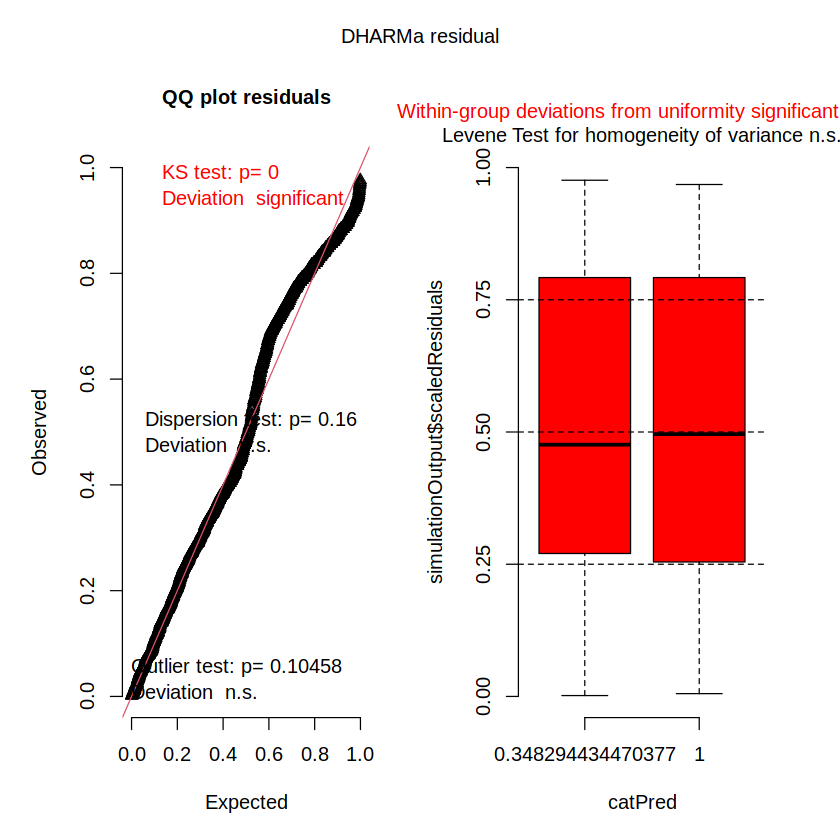

In [41]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


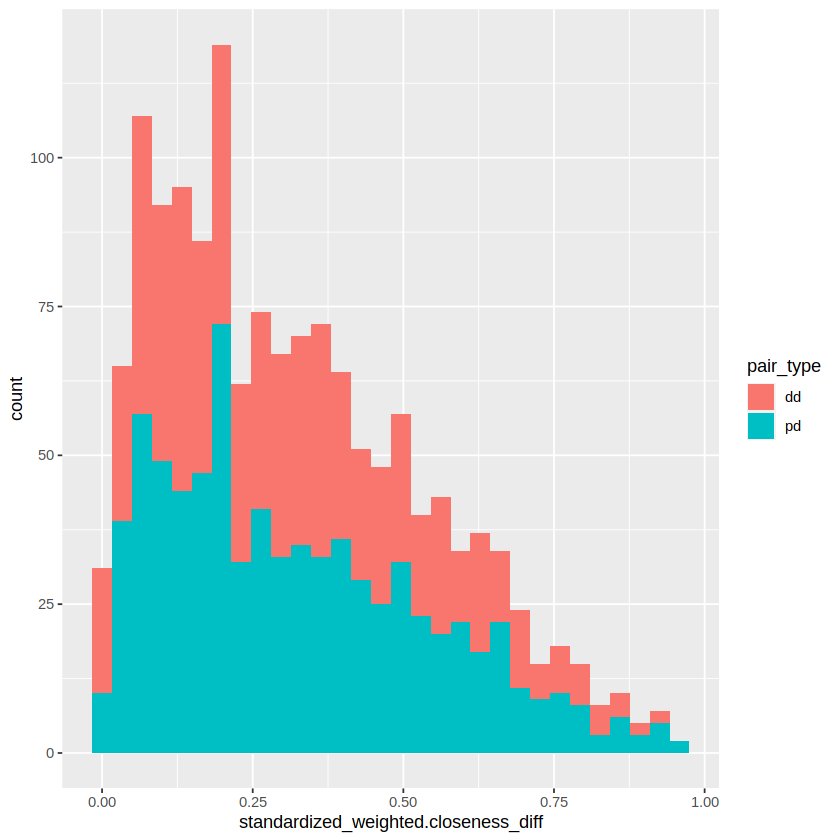

In [42]:
ggplot(pair_data, aes(x=standardized_weighted.closeness_diff, fill = pair_type)) + geom_histogram()

In [43]:
mixed = glmmTMB(formula=standardized_weighted.closeness_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.closeness_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                        ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -490.6   -458.9    251.3   -502.6     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.01343  0.1159  
 phylogenetic_dist (Intercept) 0.09186  0.3031  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family ():  4.5 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.74985    0.04340 -17.279   <2e-16 ***
pair_typepd  0.03649    0.05626   0.649    0.517    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.1292     0.2102  -19.65   <2e-16 ***
---
Signif. 

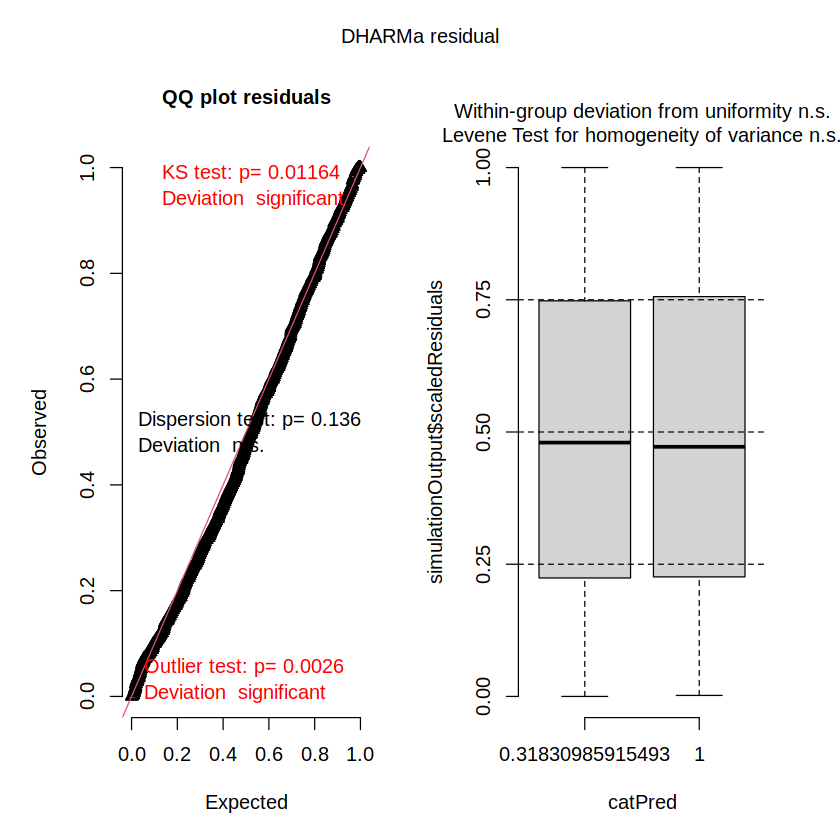

In [44]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


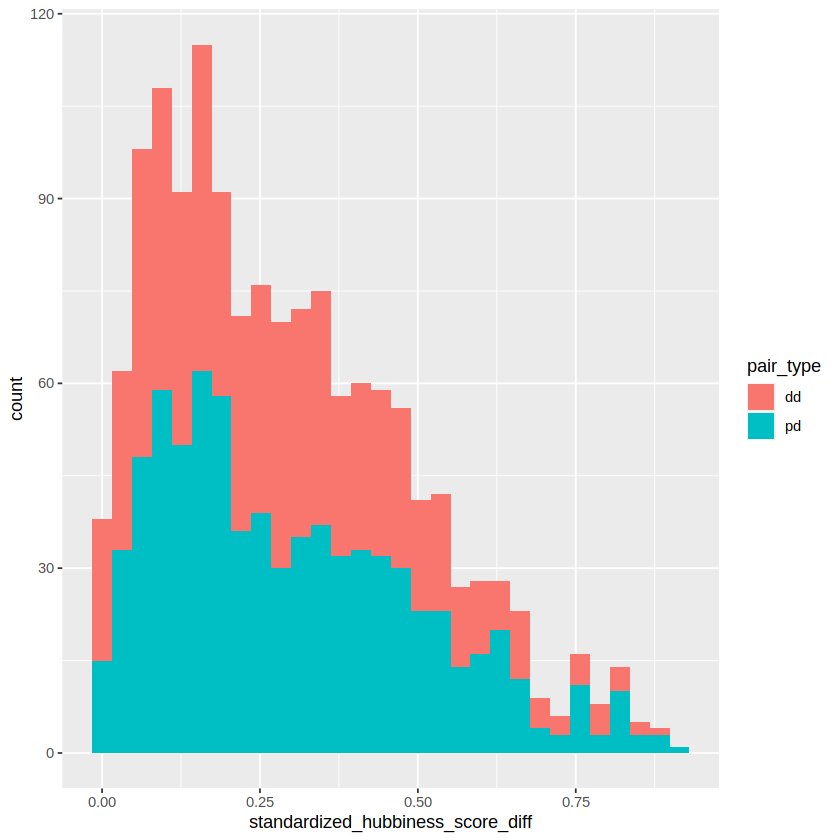

In [45]:
ggplot(pair_data, aes(x=standardized_hubbiness_score_diff, fill = pair_type)) + geom_histogram()


In [46]:
mixed = glmmTMB(formula=standardized_hubbiness_score_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_hubbiness_score_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                     ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -661.7   -630.0    336.9   -673.7     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.02040  0.1428  
 phylogenetic_dist (Intercept) 0.06243  0.2499  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 5.17 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.88265    0.04149 -21.272   <2e-16 ***
pair_typepd  0.06837    0.05284   1.294    0.196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.8586     0.1845  -20.91   <2e-16 ***
---
Signif. codes:

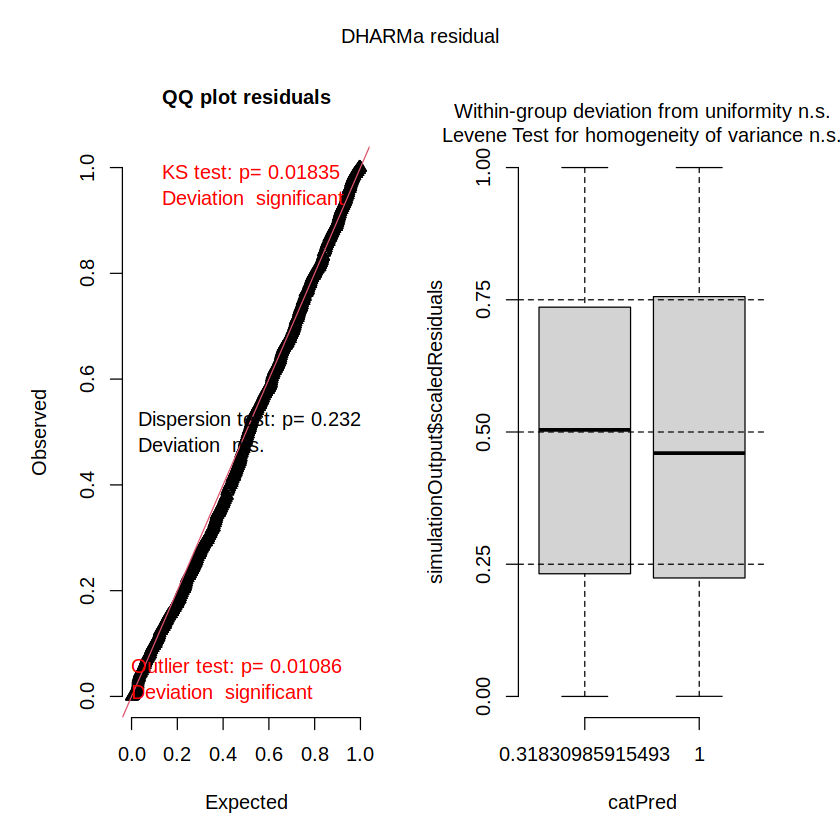

In [47]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

## compute niche overlap across pairs

In [589]:
get_niche_overlap <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = as.matrix(vegdist(network, method="horn"))
    if (!((member1 %in% rownames(res) && (member2 %in% rownames(res)))))
        {
        return(NA)
        }
    return(res[c(member1),c(member2)])  
    }

In [590]:
if (!("horn_index" %in% colnames(pair_data)))
{
    pair_data["horn_index"] = pbmcmapply(get_niche_overlap, 
                                         pair_data$network_path, 
                                         pair_data$member1, 
                                         pair_data$member2,
                                         ignore.interactive = getOption("ignore.interactive", T),
                                         mc.cores = 10)
    write.csv(pair_data, pair_data_path)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 272 rows containing non-finite values (`stat_bin()`).”


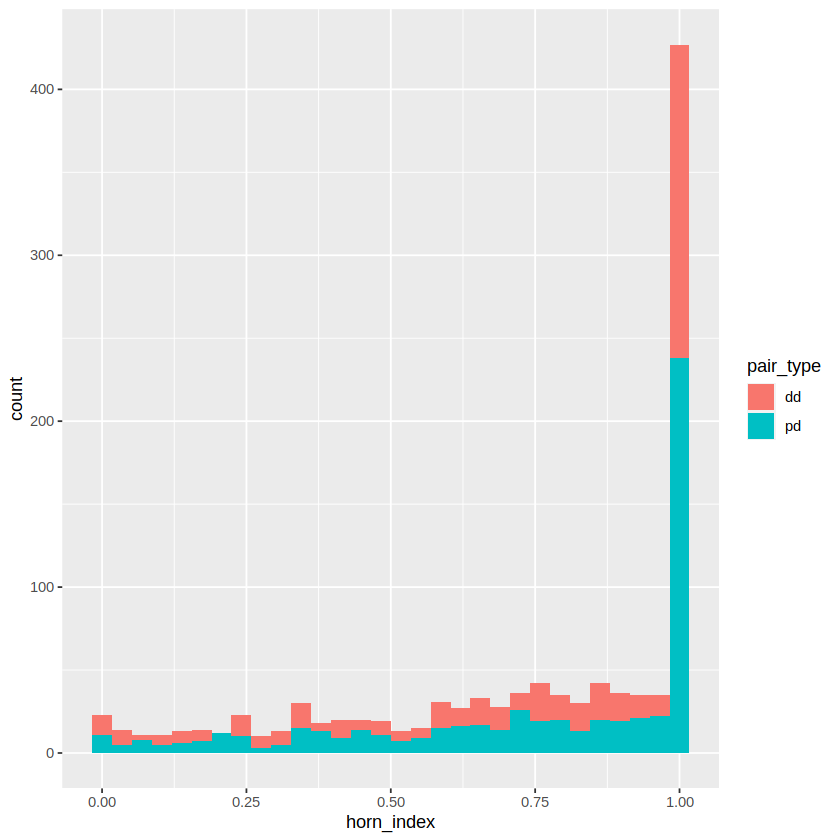

In [591]:
ggplot(pair_data, aes(x=horn_index, fill = pair_type)) + geom_histogram()

 Family: ordbeta  ( logit )
Formula:          
horn_index ~ pair_type + (1 | network_id) + (1 | phylogenetic_dist)
Data: func_data

     AIC      BIC   logLik deviance df.resid 
  1529.0   1564.2   -757.5   1515.0     1109 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.1947   0.4412  
 phylogenetic_dist (Intercept) 0.1940   0.4405  
Number of obs: 1116, groups:  network_id, 223; phylogenetic_dist, 508

Dispersion parameter for ordbeta family (): 3.19 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.55406    0.08585   6.454 1.09e-10 ***
pair_typepd  0.07694    0.08585   0.896     0.37    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


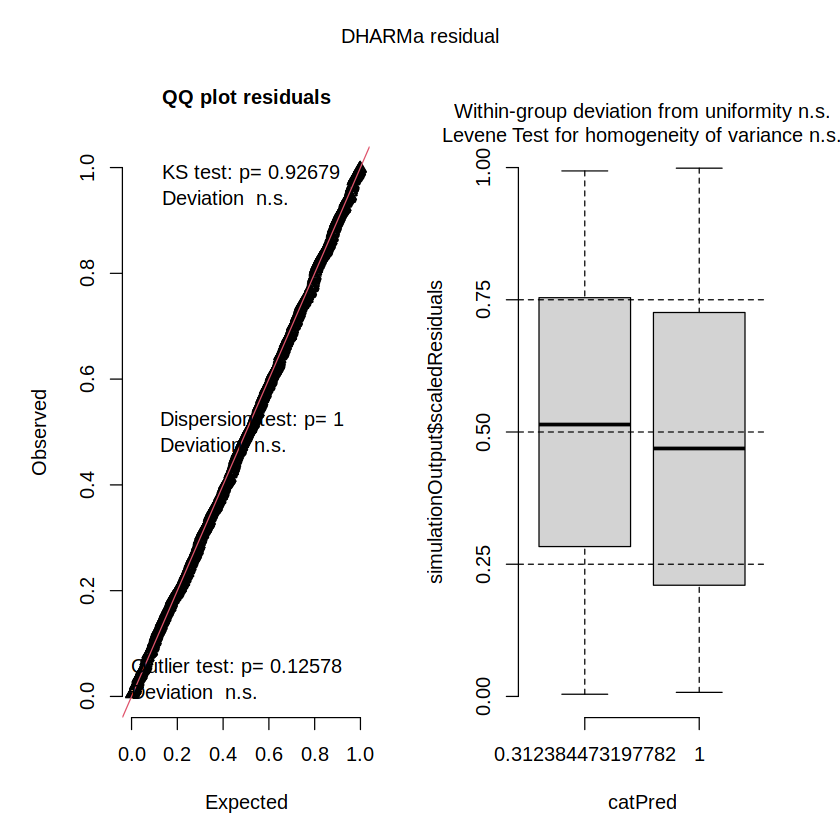

In [592]:
horn_res_df = test_pair_ploidy_level_effect("horn_index")                                         

In [593]:
horn_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,horn_index,none,NA,NA,0.55406074,0.08584804,6.4539710,1.089567e-10
network_id,horn_index,random,34.447036,4.380093e-09,NA,NA,NA,NA
pair_type,horn_index,fixed,0.801802,3.705551e-01,0.07693752,0.08585152,0.8961696,3.701622e-01
phylogenetic_dist,horn_index,random,22.917735,1.690846e-06,NA,NA,NA,NA


# compute module sharing between pairs

In [594]:
get_module_sharing <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = computeModules(network)
    modules_matrix = as.matrix(slot(res, "modules"))
    if (!((member1 %in% rownames(network) && (member2 %in% rownames(network)))))
        {
        return(NA)
        }
    m1_modules = modules_matrix[, which(member1 == rownames(network))+2] > 0
    m2_modules = modules_matrix[, which(member2 == rownames(network))+2] > 0
    frac_shared_modules = sum(m1_modules&m2_modules) / ncol(modules_matrix)
    return(frac_shared_modules)
    }

In [595]:
if (!("frac_shared_modules" %in% colnames(pair_data)))
{
pair_data["frac_shared_modules"] = pbmcmapply(get_module_sharing, 
                                     pair_data$network_path, 
                                     pair_data$member1, 
                                     pair_data$member2,
                                     ignore.interactive = getOption("ignore.interactive", T),
                                     mc.cores = 40)
    write.csv(pair_data, pair_data_path)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


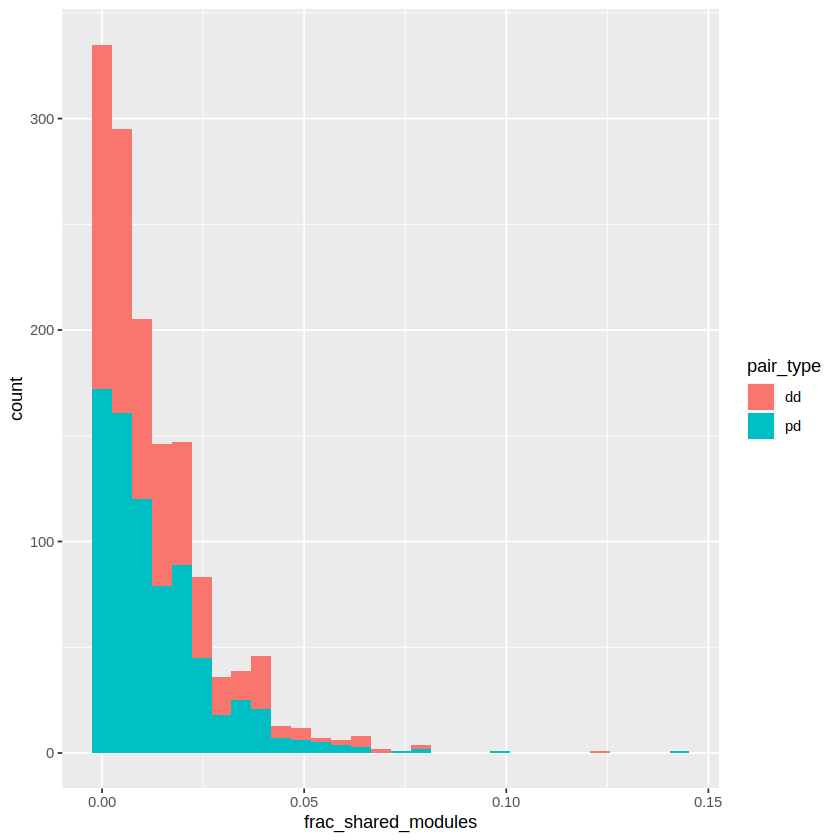

In [596]:
ggplot(pair_data, aes(x=frac_shared_modules, fill = pair_type)) + geom_histogram()

 Family: ordbeta  ( logit )
Formula:          
frac_shared_modules ~ pair_type + (1 | network_id) + (1 | phylogenetic_dist)
Data: func_data

     AIC      BIC   logLik deviance df.resid 
 -7234.0  -7197.3   3624.0  -7248.0     1381 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 1.20106  1.0959  
 phylogenetic_dist (Intercept) 0.03002  0.1733  
Number of obs: 1388, groups:  network_id, 282; phylogenetic_dist, 573

Dispersion parameter for ordbeta family ():  903 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.32141    0.08173  -52.87   <2e-16 ***
pair_typepd -0.04849    0.02799   -1.73   0.0832 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


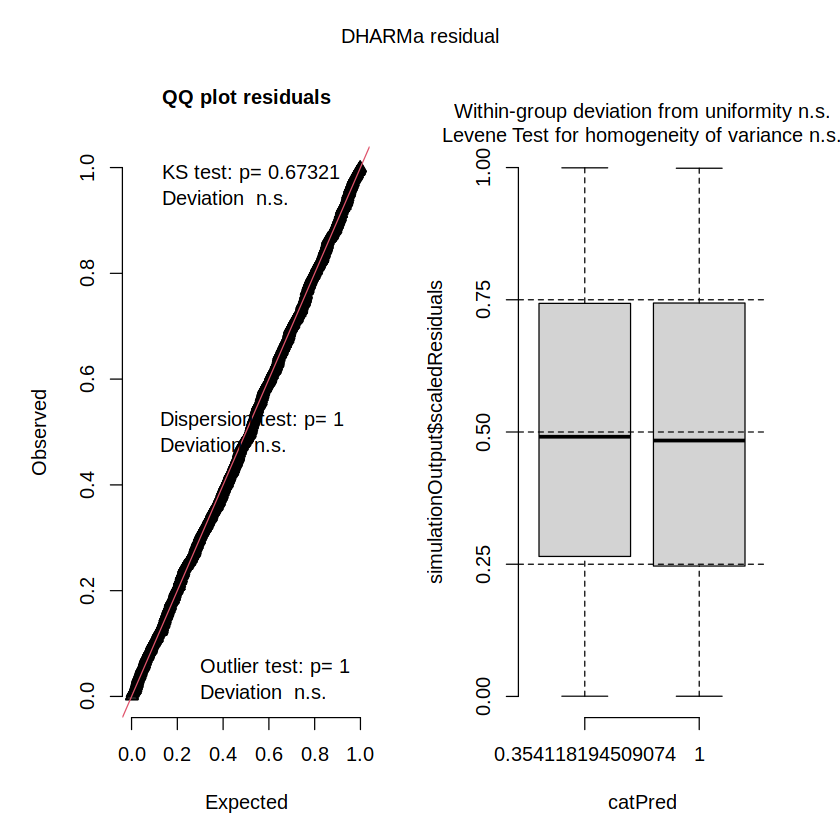

In [597]:
mod_res_df = test_pair_ploidy_level_effect("frac_shared_modules")                                         

In [598]:
mod_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,frac_shared_modules,none,NA,NA,-4.32140700,0.08173475,-52.871113,0.00000000
network_id,frac_shared_modules,random,1127.194740,4.058151e-247,NA,NA,NA,NA
pair_type,frac_shared_modules,fixed,2.999912,8.326902e-02,-0.04848566,0.02798639,-1.732473,0.08318937
phylogenetic_dist,frac_shared_modules,random,67.632552,1.969883e-16,NA,NA,NA,NA


In [599]:
full_pair_df = rbind(horn_res_df, mod_res_df)
full_pair_df["significant_by_lrt"] = full_pair_df$lrt_pvalue <= 0.05
full_pair_df["significant_by_wald_test"] = full_pair_df$z_test_pvalue <= 0.05
write.csv(full_pair_df, res_pair_path)

In [600]:
round_df(full_pair_df)

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,significant_by_lrt,significant_by_wald_test
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Intercept,horn_index,none,NA,NA,0.55406,0.08585,6.45397,0.00000,NA,TRUE
network_id,horn_index,random,34.44704,0.00000,NA,NA,NA,NA,TRUE,NA
pair_type,horn_index,fixed,0.80180,0.37056,0.07694,0.08585,0.89617,0.37016,FALSE,FALSE
phylogenetic_dist,horn_index,random,22.91773,0.00000,NA,NA,NA,NA,TRUE,NA
Intercept1,frac_shared_modules,none,NA,NA,-4.32141,0.08173,-52.87111,0.00000,NA,TRUE
network_id1,frac_shared_modules,random,1127.19474,0.00000,NA,NA,NA,NA,TRUE,NA
pair_type1,frac_shared_modules,fixed,2.99991,0.08327,-0.04849,0.02799,-1.73247,0.08319,FALSE,FALSE
phylogenetic_dist1,frac_shared_modules,random,67.63255,0.00000,NA,NA,NA,NA,TRUE,NA
